# Estimation of Autocorrelation Function (tensor contraction)

## (2d Ising model on Square Lattice with J > 0)

In [66]:
import numpy as np
import numba as nb

In [67]:
import csv
import pickle
import time
from tqdm.auto import trange

In [68]:
import matplotlib.pyplot as plt

In [69]:
types_corr_k_steps_est = nb.types.Tuple((nb.float64, nb.float64, nb.float64[:]))(nb.float64[:], nb.int64)
@nb.cfunc(types_corr_k_steps_est, parallel=True)
def corr_k_step_est_float(sample_array, k_steps_max):
    """
    Args:
        mc_list: (np.array)
        k_steps: (int)
    Return:
        corr_coef: (float)
    """
    sample_len = len(sample_array)
    num_i_steps = sample_len - k_steps_max
    q_mean = np.mean(sample_array[:num_i_steps])
    q_square_mean = np.mean(np.square(sample_array[:num_i_steps]))
    qqk_sum = np.zeros(k_steps_max)
    for i in range(num_i_steps):
        samples_k_sub = sample_array[i:i+k_steps_max+1]
        for j in range(1, k_steps_max+1):
            qqk_sum[j-1] += (samples_k_sub[0] * samples_k_sub[j])
    qqk_array = qqk_sum / num_i_steps
    return (q_mean, q_square_mean, qqk_array)

In [70]:
types_corr_k_steps_est = nb.types.Tuple((nb.float64, nb.float64, nb.float64[:]))(nb.int32[:], nb.int64)
@nb.cfunc(types_corr_k_steps_est, parallel=True)
def corr_k_step_est_int(sample_array, k_steps_max):
    """
    Args:
        mc_list: (np.array)
        k_steps: (int)
    Return:
        corr_coef: (float)
    """
    sample_len = len(sample_array)
    num_i_steps = sample_len - k_steps_max
    q_mean = np.mean(sample_array[:num_i_steps])
    q_square_mean = np.mean(np.square(sample_array[:num_i_steps]))
    qqk_sum = np.zeros(k_steps_max)
    for i in range(num_i_steps):
        samples_k_sub = sample_array[i:i+k_steps_max+1]
        for j in range(1, k_steps_max+1):
            qqk_sum[j-1] += (samples_k_sub[0] * samples_k_sub[j])
    qqk_array = qqk_sum / num_i_steps
    return (q_mean, q_square_mean, qqk_array)

In [71]:
@nb.njit(parallel=True)
def autocorr_mc_mean_est(mc_array, k_steps_max):
    m_times = mc_array.shape[0]
    qqk_mean_mc, qqk_mean_std_mc = np.zeros(k_steps_max), np.zeros(k_steps_max)
    q_mean_array, q_square_mean_array, qqk_double_array = np.zeros(m_times), np.zeros(m_times), np.zeros((m_times, k_steps_max))
    for i in range(m_times):
        q_mean, q_square_mean, qqk_array = corr_k_step_est_float(mc_array[i], k_steps_max)
        q_mean_array[i] = q_mean
        q_square_mean_array[i] = q_square_mean
        qqk_double_array[i] = qqk_array
    for i in range(k_steps_max):
        qqk_mean_mc_i = np.mean(qqk_double_array[:, i])
        qqk_mean_std_mc_i = np.std(qqk_double_array[:, i])
        qqk_mean_mc[i] = qqk_mean_mc_i
        qqk_mean_std_mc[i] = qqk_mean_std_mc_i / np.sqrt(m_times)
    ####################################################
    q_mean_mc = np.mean(q_mean_array)
    q_mean_std_mc = np.std(q_mean_array) / np.sqrt(m_times)
    q_square_mean_mc = np.mean(q_square_mean_array)
    q_square_mean_std_mc = np.std(q_square_mean_array) / np.sqrt(m_times)
    ####################################################
    q_mean = (q_mean_mc, q_mean_std_mc)
    q_square_mean = (q_square_mean_mc, q_square_mean_std_mc)
    qqk_mean = (qqk_mean_mc, qqk_mean_std_mc)
    ####################################################
    autocorr_mc = (qqk_mean_mc - q_mean_mc ** 2) / (q_square_mean_mc - q_mean_mc ** 2) 
    return autocorr_mc, q_mean, q_square_mean, qqk_mean

In [72]:
@nb.njit(parallel=True)
def autocorr_mc_std_est(mc_array, k_steps_max):
    m_times = mc_array.shape[0]
    qqk_mean_mc, qqk_mean_std_mc = np.zeros(k_steps_max), np.zeros(k_steps_max)
    q_mean_array, q_square_mean_array, qqk_double_array = np.zeros((m_times, 1)), np.zeros((m_times, 1)), np.zeros((m_times, k_steps_max))
    autocorr_mc_mean, autocorr_mc_std = np.zeros(k_steps_max), np.zeros(k_steps_max)
    for i in range(m_times):
        q_mean, q_square_mean, qqk_array = corr_k_step_est_float(mc_array[i], k_steps_max)
        q_mean_array[i] = q_mean
        q_square_mean_array[i] = q_square_mean
        qqk_double_array[i] = qqk_array        
    ####################################################
    autocorr_mc_array = (qqk_double_array - q_mean_array ** 2) / (q_square_mean_array - q_mean_array ** 2)
    q_mean_mc = np.mean(q_mean_array)
    q_square_mean_mc = np.mean(q_square_mean_array)
    qqk_mc = np.mean(qqk_double_array)
    for j in range(k_steps_max):
        autocorr_mc_mean[j] = np.mean(autocorr_mc_array[:, j])
        autocorr_mc_std[j] = np.std(autocorr_mc_array[:, j]) / np.sqrt(m_times)
    return autocorr_mc_mean, autocorr_mc_std

In [73]:
def autocorr_time_est(autocorr_fun_list, t_trunc):
    num_steps = len(autocorr_fun_list)
    coeff_auto = np.polyfit(np.arange(num_steps), np.log(autocorr_fun_list), 1)
    k, b = coeff_auto
    auto_time_up = 1 / k * np.exp(k * t_trunc + b)
    auto_time_down = 1 / k
    autocorr_time = auto_time_up - auto_time_down  
    return autocorr_time

-----------
### 4 x 4 Square 2D Ising Model

In [74]:
with open('./data_2d_ising/ising2d_size_4_beta_0.441_block_tensor_5E6_m.pkl', 'rb') as file:
    m_2dising_4_j_pos = pickle.load(file)

In [75]:
m_abs_2dising_4_j_pos = np.abs(m_2dising_4_j_pos)

In [76]:
m_abs_2dising_4_j_pos = m_abs_2dising_4_j_pos.reshape((5000, 1000))

In [77]:
time_start = time.time()
autocorr_m_abs_2dising_4_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_4_j_pos, 100)
_, autocorr_m_abs_2dising_4_j_pos_std = autocorr_mc_std_est(m_abs_2dising_4_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

19.47375249862671


In [78]:
autocorr_m_abs_2dising_4_j_pos_mean = np.insert(autocorr_m_abs_2dising_4_j_pos_mean, 0, 1)

In [79]:
autocorr_m_abs_2dising_4_j_pos_std = np.insert(autocorr_m_abs_2dising_4_j_pos_std, 0, 0)

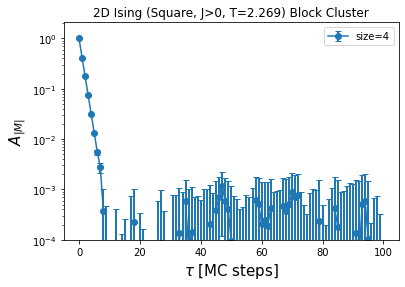

In [80]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_4_j_pos_mean, yerr=autocorr_m_abs_2dising_4_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Block Cluster")
plt.legend()

In [81]:
m_abs_2dising_4_j_pos_mean = np.mean(m_abs_2dising_4_j_pos)

In [82]:
print(f"|m| of size 4 is: {m_abs_2dising_4_j_pos_mean:.3f}.")

|m| of size 4 is: 0.844.


In [83]:
autocorr_time_size_4 = np.sum(autocorr_m_abs_2dising_4_j_pos_mean) - 1/2

In [84]:
print(f"autocorr time of size 4 is: {autocorr_time_size_4:.3f}.")

autocorr time of size 4 is: 1.203.


In [85]:
autocorr_time_size_4 = autocorr_time_est(autocorr_m_abs_2dising_4_j_pos_mean[:8], 10000)

In [86]:
autocorr_time_size_4

1.174602797231543

----
### Size = 8

In [87]:
with open('./data_2d_ising/ising2d_size_8_beta_0.441_block_tensor_5E6_m.pkl', 'rb') as file:
    m_2dising_8_j_pos = pickle.load(file)

In [88]:
m_abs_2dising_8_j_pos = np.abs(m_2dising_8_j_pos)

In [89]:
m_abs_2dising_8_j_pos_mean = np.mean(m_abs_2dising_8_j_pos)

In [90]:
print(f"|m| of size 8 is: {m_abs_2dising_8_j_pos_mean:.3f}.")

|m| of size 8 is: 0.777.


In [91]:
m_abs_2dising_8_j_pos = m_abs_2dising_8_j_pos.reshape((5000, 1000))

In [92]:
time_start = time.time()
autocorr_m_abs_2dising_8_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_8_j_pos, 100)
_, autocorr_m_abs_2dising_8_j_pos_std = autocorr_mc_std_est(m_abs_2dising_8_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

4.73543643951416


In [93]:
autocorr_m_abs_2dising_8_j_pos_mean = np.insert(autocorr_m_abs_2dising_8_j_pos_mean, 0, 1)

In [94]:
autocorr_m_abs_2dising_8_j_pos_std = np.insert(autocorr_m_abs_2dising_8_j_pos_std, 0, 0)

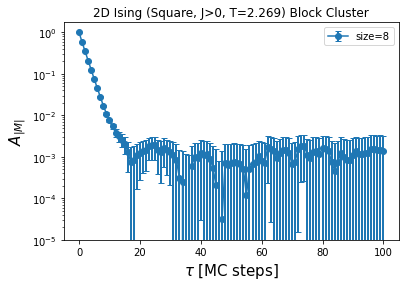

In [95]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_8_j_pos_mean, yerr=autocorr_m_abs_2dising_8_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.yscale("log")
plt.ylim(10**-5)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Block Cluster")
plt.legend()

In [96]:
autocorr_time_size_8 = np.sum(autocorr_m_abs_2dising_8_j_pos_mean) - 1/2

In [97]:
print(f"autocorr time of size 8 is: {autocorr_time_size_8:.3f}.")

autocorr time of size 8 is: 2.052.


In [98]:
autocorr_time_size_8 = autocorr_time_est(autocorr_m_abs_2dising_8_j_pos_mean[:2], 10000)

In [99]:
print(f"autocorr time of size 8 is: {autocorr_time_size_8:.3f}.")

autocorr time of size 8 is: 1.849.


-----------
### Size = 16

In [100]:
with open('./data_2d_ising/ising2d_size_16_beta_0.441_j_pos_block_tensor_torch/ising2d_size_16_beta_0.441_j_pos_block_tensor_1E5_m.pkl', 'rb') as file:
    m_2dising_16_j_pos = pickle.load(file)

In [101]:
with open('./data_2d_ising/ising2d_size_16_beta_0.441_j_pos_block_tensor_torch/ising2d_size_16_beta_0.441_j_pos_block_tensor_1E5_m_v1.pkl', 'rb') as file:
    m_2dising_16_j_pos_v1 = pickle.load(file)

In [102]:
with open('./data_2d_ising/ising2d_size_16_beta_0.441_j_pos_block_tensor_torch/ising2d_size_16_beta_0.441_j_pos_block_tensor_1E5_m_v4.pkl', 'rb') as file:
    m_2dising_16_j_pos_v4 = pickle.load(file)

In [103]:
with open('./data_2d_ising/ising2d_size_16_beta_0.441_j_pos_block_tensor_torch/ising2d_size_16_beta_0.441_j_pos_block_tensor_1E5_m_v5.pkl', 'rb') as file:
    m_2dising_16_j_pos_v5 = pickle.load(file)

In [104]:
with open('./data_2d_ising/ising2d_size_16_beta_0.441_j_pos_block_tensor_torch/ising2d_size_16_beta_0.441_j_pos_block_tensor_1E5_m_v6.pkl', 'rb') as file:
    m_2dising_16_j_pos_v6 = pickle.load(file)

In [105]:
with open('./data_2d_ising/ising2d_size_16_beta_0.441_j_pos_block_tensor_torch/ising2d_size_16_beta_0.441_j_pos_block_tensor_1E5_m_v7.pkl', 'rb') as file:
    m_2dising_16_j_pos_v7 = pickle.load(file)

In [106]:
m_abs_2dising_16_j_pos = np.abs(m_2dising_16_j_pos)

In [107]:
m_abs_2dising_16_j_pos_v1 = np.abs(m_2dising_16_j_pos_v1)

In [108]:
m_abs_2dising_16_j_pos_v4 = np.abs(m_2dising_16_j_pos_v4)

In [109]:
m_abs_2dising_16_j_pos_v5 = np.abs(m_2dising_16_j_pos_v5)

In [110]:
m_abs_2dising_16_j_pos_v6 = np.abs(m_2dising_16_j_pos_v6)

In [111]:
m_abs_2dising_16_j_pos_v7 = np.abs(m_2dising_16_j_pos_v7)

In [112]:
m_abs_2dising_16_j_pos = m_abs_2dising_16_j_pos.reshape((100, 1000))

In [113]:
m_abs_2dising_16_j_pos_v1 = m_abs_2dising_16_j_pos_v1.reshape((150, 1000))

In [114]:
m_abs_2dising_16_j_pos_v4 = m_abs_2dising_16_j_pos_v4.reshape((150, 1000))

In [115]:
m_abs_2dising_16_j_pos_v5 = m_abs_2dising_16_j_pos_v5.reshape((150, 1000))

In [116]:
m_abs_2dising_16_j_pos_v7 = m_abs_2dising_16_j_pos_v7.reshape((150, 1000))

In [117]:
m_abs_2dising_16_j_pos.shape

(100, 1000)

In [118]:
m_abs_2dising_16_j_pos = np.concatenate((m_abs_2dising_16_j_pos, 
                                         m_abs_2dising_16_j_pos_v1,
                                         m_abs_2dising_16_j_pos_v4,
                                         m_abs_2dising_16_j_pos_v5,
                                         m_abs_2dising_16_j_pos_v7), axis=0)

In [119]:
m_abs_2dising_16_j_pos_mean = np.mean(m_abs_2dising_16_j_pos)

In [120]:
print(f"|m| of size 16 is: {m_abs_2dising_16_j_pos_mean:.3f}.")

|m| of size 16 is: 0.713.


In [121]:
time_start = time.time()
autocorr_m_abs_2dising_16_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_16_j_pos, 100)
_, autocorr_m_abs_2dising_16_j_pos_std = autocorr_mc_std_est(m_abs_2dising_16_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

0.7382628917694092


In [122]:
autocorr_m_abs_2dising_16_j_pos_mean = np.insert(autocorr_m_abs_2dising_16_j_pos_mean, 0, 1)

In [123]:
autocorr_m_abs_2dising_16_j_pos_std = np.insert(autocorr_m_abs_2dising_16_j_pos_std, 0, 0)

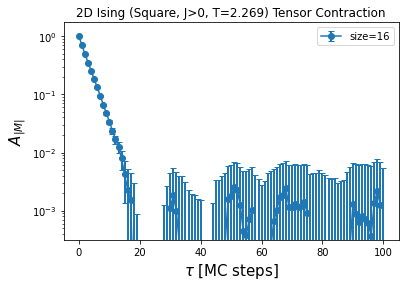

In [124]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_16_j_pos_mean, yerr=autocorr_m_abs_2dising_16_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.yscale("log")
plt.ylim(10**-3.5)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contraction")
plt.legend()

In [177]:
autocorr_time_size_16 = np.sum(autocorr_m_abs_2dising_16_j_pos_mean) - 1/2

In [178]:
print(f"autocorr time of size 16 is: {autocorr_time_size_16:.3f}.")

autocorr time of size 16 is: 2.870.


In [141]:
autocorr_time_size_16 = autocorr_time_est(autocorr_m_abs_2dising_16_j_pos_mean[:14], 10000)

In [142]:
print(f"autocorr time of size 16 is: {autocorr_time_size_16:.3f}.")

autocorr time of size 16 is: 2.970.


-----------
### Size = 32

In [10]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_1E4_m.pkl', 'rb') as file:
    m_2dising_32_j_pos = pickle.load(file)

In [13]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_1E4_m_v0.pkl', 'rb') as file:
    m_2dising_32_j_pos_v0 = pickle.load(file)

In [14]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_1E4_m_v1.pkl', 'rb') as file:
    m_2dising_32_j_pos_v1 = pickle.load(file)

In [15]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_1E4_m_v2.pkl', 'rb') as file:
    m_2dising_32_j_pos_v2 = pickle.load(file)

In [16]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_1E4_m_v3.pkl', 'rb') as file:
    m_2dising_32_j_pos_v3 = pickle.load(file)

In [17]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_1E4_m_v4.pkl', 'rb') as file:
    m_2dising_32_j_pos_v4 = pickle.load(file)

In [18]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_1E4_m_v5.pkl', 'rb') as file:
    m_2dising_32_j_pos_v5 = pickle.load(file)

In [19]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_1E4_m_v6.pkl', 'rb') as file:
    m_2dising_32_j_pos_v6 = pickle.load(file)

In [20]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_1E4_m_v7.pkl', 'rb') as file:
    m_2dising_32_j_pos_v7 = pickle.load(file)

In [21]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_1E4_m_v8.pkl', 'rb') as file:
    m_2dising_32_j_pos_v8 = pickle.load(file)

In [22]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_1E4_m_v9.pkl', 'rb') as file:
    m_2dising_32_j_pos_v9 = pickle.load(file)

In [23]:
with open('./data_2d_ising/ising2d_size_32_beta_0.441_j_pos_block_tensor_torch/ising2d_size_32_beta_0.441_j_pos_block_tensor_5E4_m.pkl', 'rb') as file:
    m_2dising_32_j_pos_v10 = pickle.load(file)

In [24]:
m_abs_2dising_32_j_pos = np.abs(m_2dising_32_j_pos)

In [25]:
m_abs_2dising_32_j_pos_v0 = np.abs(m_2dising_32_j_pos_v0)

In [26]:
m_abs_2dising_32_j_pos_v1 = np.abs(m_2dising_32_j_pos_v1)

In [27]:
m_abs_2dising_32_j_pos_v2 = np.abs(m_2dising_32_j_pos_v2)

In [28]:
m_abs_2dising_32_j_pos_v3 = np.abs(m_2dising_32_j_pos_v3)

In [29]:
m_abs_2dising_32_j_pos_v4 = np.abs(m_2dising_32_j_pos_v4)

In [30]:
m_abs_2dising_32_j_pos_v5 = np.abs(m_2dising_32_j_pos_v5)

In [31]:
m_abs_2dising_32_j_pos_v6 = np.abs(m_2dising_32_j_pos_v6)

In [32]:
m_abs_2dising_32_j_pos_v7 = np.abs(m_2dising_32_j_pos_v7)

In [33]:
m_abs_2dising_32_j_pos_v8 = np.abs(m_2dising_32_j_pos_v8)

In [34]:
m_abs_2dising_32_j_pos_v9 = np.abs(m_2dising_32_j_pos_v9)

In [35]:
m_abs_2dising_32_j_pos_v10 = np.abs(m_2dising_32_j_pos_v10)

In [37]:
m_abs_2dising_32_j_pos = m_abs_2dising_32_j_pos.reshape((10, 1000))

In [39]:
m_abs_2dising_32_j_pos_v0 = m_abs_2dising_32_j_pos_v0.reshape((10, 1000))

In [41]:
m_abs_2dising_32_j_pos_v1 = m_abs_2dising_32_j_pos_v1.reshape((10, 1000))

In [43]:
m_abs_2dising_32_j_pos_v2 = m_abs_2dising_32_j_pos_v2.reshape((10, 1000))

In [44]:
m_abs_2dising_32_j_pos_v3 = m_abs_2dising_32_j_pos_v3.reshape((10, 1000))

In [45]:
m_abs_2dising_32_j_pos_v4 = m_abs_2dising_32_j_pos_v4.reshape((10, 1000))

In [46]:
m_abs_2dising_32_j_pos_v5 = m_abs_2dising_32_j_pos_v5.reshape((10, 1000))

In [47]:
m_abs_2dising_32_j_pos_v6 = m_abs_2dising_32_j_pos_v6.reshape((10, 1000))

In [48]:
m_abs_2dising_32_j_pos_v7 = m_abs_2dising_32_j_pos_v7.reshape((10, 1000))

In [49]:
m_abs_2dising_32_j_pos_v8 = m_abs_2dising_32_j_pos_v8.reshape((10, 1000))

In [50]:
m_abs_2dising_32_j_pos_v9 = m_abs_2dising_32_j_pos_v9.reshape((10, 1000))

In [52]:
m_abs_2dising_32_j_pos_v10 = m_abs_2dising_32_j_pos_v10.reshape((50, 1000))

In [53]:
m_abs_2dising_32_j_pos = np.concatenate((m_abs_2dising_32_j_pos, m_abs_2dising_32_j_pos_v0,
                                         m_abs_2dising_32_j_pos_v1, m_abs_2dising_32_j_pos_v2, 
                                         m_abs_2dising_32_j_pos_v3, m_abs_2dising_32_j_pos_v4,
                                         m_abs_2dising_32_j_pos_v5, m_abs_2dising_32_j_pos_v6, 
                                         m_abs_2dising_32_j_pos_v7, m_abs_2dising_32_j_pos_v8, 
                                         m_abs_2dising_32_j_pos_v9, m_abs_2dising_32_j_pos_v10), axis=0)

In [54]:
m_abs_2dising_32_j_pos_mean = np.mean(m_abs_2dising_32_j_pos)

In [55]:
print(f"|m| of size 32 is: {m_abs_2dising_32_j_pos_mean:.3f}.")

|m| of size 32 is: 0.654.


In [56]:
time_start = time.time()
autocorr_m_abs_2dising_32_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_32_j_pos, 100)
_, autocorr_m_abs_2dising_32_j_pos_std = autocorr_mc_std_est(m_abs_2dising_32_j_pos, 100)
time_end = time.time()
print(time_end-time_start)

14.956312417984009


In [57]:
autocorr_m_abs_2dising_32_j_pos_mean = np.insert(autocorr_m_abs_2dising_32_j_pos_mean, 0, 1)

In [58]:
autocorr_m_abs_2dising_32_j_pos_std = np.insert(autocorr_m_abs_2dising_32_j_pos_std, 0, 0)

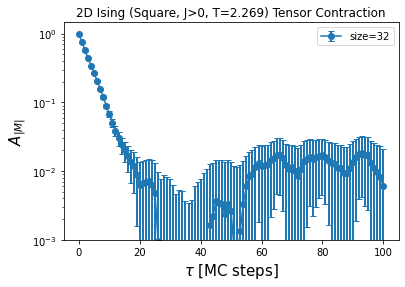

In [59]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_32_j_pos_mean, yerr=autocorr_m_abs_2dising_32_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Tensor Contraction")
plt.legend()

In [165]:
autocorr_time_size_32 = np.sum(autocorr_m_abs_2dising_32_j_pos_mean) - 1/2

In [166]:
print(f"autocorr time of size 32 is: {autocorr_time_size_32:.3f}.")

autocorr time of size 32 is: 4.340.


In [163]:
autocorr_time_size_32 = autocorr_time_est(autocorr_m_abs_2dising_32_j_pos_mean[:9], 10000)

In [164]:
autocorr_time_size_32

3.822056117540396

--------------
#### Summary

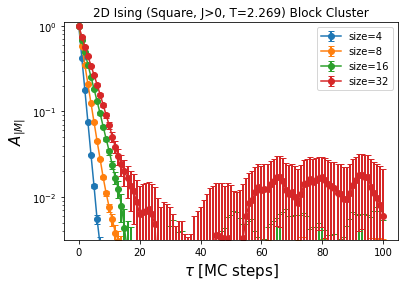

In [167]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_4_j_pos_mean, yerr=autocorr_m_abs_2dising_4_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_8_j_pos_mean, yerr=autocorr_m_abs_2dising_8_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_16_j_pos_mean, yerr=autocorr_m_abs_2dising_16_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_32_j_pos_mean, yerr=autocorr_m_abs_2dising_32_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-2.5, 1.1)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Block Cluster")
plt.legend()

### Size effect and Dynamical Exponent

In [168]:
size_array = np.array([4, 8, 16, 32])

In [169]:
autocorr_fun_array = np.array([m_abs_2dising_4_j_pos_mean, 
                               m_abs_2dising_8_j_pos_mean,
                               m_abs_2dising_16_j_pos_mean,
                               m_abs_2dising_32_j_pos_mean])

Text(0.5, 1.0, 'Size Effect on Square 2D Ising (J > 0) Block Tensor')

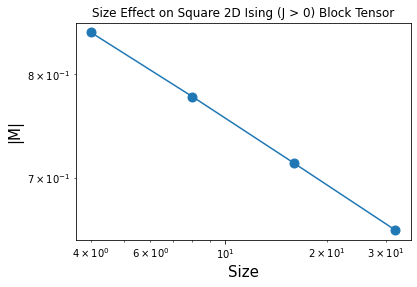

In [188]:
plt.plot(size_array, autocorr_fun_array, '-o', markersize=9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Size", fontsize=15)
plt.ylabel("|M|", fontsize=15)
plt.title("Size Effect on Square 2D Ising (J > 0) Block Tensor")

In [179]:
autocorr_time_array = np.array([autocorr_time_size_4, autocorr_time_size_8,
                                autocorr_time_size_16, autocorr_time_size_32])
size_array = np.array([4, 8, 16, 32])

In [180]:
autocorr_time_array

array([1.1746028 , 1.84862495, 2.86999912, 4.3395949 ])

In [181]:
index_metropolis, bias = np.polyfit(np.log(size_array), np.log(autocorr_time_array), 1)

In [182]:
print(f"index of metropolis is about: {index_metropolis:.3f}.")

index of metropolis is about: 0.629.


Text(0.5, 1.0, 'Block Tensor on Ising 2D Square Lattice (J > 0), Z=0.629')

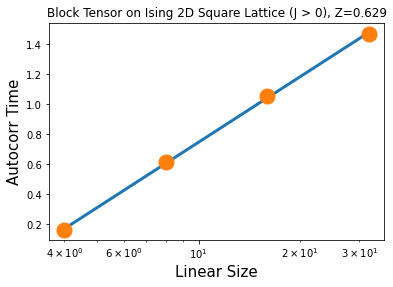

In [187]:
plt.plot(size_array, index_metropolis*np.log(size_array) + bias, linewidth=3)
plt.plot(size_array, np.log(autocorr_time_array), 'o', markersize=15)
plt.xscale('log')
plt.xlabel("Linear Size", fontsize=15)
plt.ylabel("Autocorr Time", fontsize=15)
plt.title("Block Tensor on Ising 2D Square Lattice (J > 0), Z=0.629")

----------------